# Purpose of this notebook
This notebook shows how TEMPEST is trained. 
TEMPEST is a motion estimation that can learn DVFs from undersampled MRI. 
It employs a multi-resolution approach, limiting the impact of undersampling artifacts

The goal is that, given the proper paths and data, you can train your own TEMPEST model.

This approach is proposed and evaluated in the publication by Terpstra et al. "Real-time 3D motion estimation from undersampled MRI using multi-resolution neural networks" (https://doi.org/10.1002/mp.15217)


## Preparations
First, we install some packages:

In [ ]:
!pip install numpy matplotlib torch==1.8.1 Pillow h5py scikit-image tqdm scipy

For data augmentation, we use TorchIO. However, it does not have support for DVFs out-of-the-box, so we made our own fork supporting this feature. When this work was produced, TorchIO also couldn't load arbitrary HDF5 files. Therefore, this fork also facilitates loading data from arbitrary sources. The current version of TorchIO (at the time of writing) supports this out-of-the-box.

In [ ]:
!pip install "git+https://github.com/maartenterpstra/torchio.git#egg=torchio"

In [ ]:
# Select GPU to train on
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

# enable inline plotting of matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# base libraries
import torch
import torch.nn.functional as F
import numpy as np
import random

# torchio for data handling
import torchio
from torchio.transforms import Compose, OneOf, RandomBiasField, RandomNoise, ZNormalization, RandomFlip

# helper functions
from glob import glob              # to discover files in folder according to pattern
from copy import deepcopy          # to prevent in-place editing of data
import hiddenlayer as hl           # to show training metrics 
from tqdm.notebook import tqdm     # to show progress during training
import scipy.ndimage               # to warp an image according to a DVF

Proper initizialization of the randomness ensures reprodcibility and correct training

In [2]:
# This function sets the random seeds for the various libraries that we use.
# Also, it disables benchmarking and enables deterministic runtimes.
# This has a minor performance impact but makes the experiments more reproducible.

# Today, we can also call `torch.use_deterministic_algorithms(True)`, but this did not exist at the time of writing
def set_seed(seed):
    if not seed:
        seed = 10
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [3]:
## This function downsamples the columns of an image by keeping every n-th column
def downsample(x, N):
    x = deepcopy(x)
    return x[:, ::N]

# Display a three orthogonal slices of a 3D DVF on three axes
def display_dvf(motion_field_X, motion_field_Y, motion_field_Z, display_slice_z, display_slice_y, display_slice_x, dimx, dimy, dimz, ax1, ax2, ax3):
    display_motion_number = 20;
    motion_field_display_factor = round(max(dimx, dimy)/display_motion_number);
    x_field = np.flipud(motion_field_Y[:,:,display_slice_z])
    y_field = -np.flipud(motion_field_X[:,:,display_slice_z])
    ax1.quiver(downsample(downsample(x_field, motion_field_display_factor).T,motion_field_display_factor).T / (motion_field_display_factor/2), 
                       downsample(downsample(y_field, motion_field_display_factor).T,motion_field_display_factor).T / (motion_field_display_factor/2),
                    scale=0.0003, scale_units='dots')
    motion_field_display_factor = round(max(dimx, dimz)/display_motion_number);

    x_field = -(np.flipud(motion_field_X[:,display_slice_y,:]).T)
    y_field = -(-np.flipud(motion_field_Z[:,display_slice_y,:]).T)
    ax2.quiver(downsample(downsample(x_field, motion_field_display_factor).T,motion_field_display_factor).T / (motion_field_display_factor/2), 
                       downsample(downsample(y_field, motion_field_display_factor).T,motion_field_display_factor).T / (motion_field_display_factor/2),
                    scale=0.0003, scale_units='dots')
    
    motion_field_display_factor = round(max(dimy, dimy)/display_motion_number);
    x_field = -(np.flipud(motion_field_Y[display_slice_x,:,:]).T)
    y_field = -(-np.flipud(motion_field_Z[display_slice_x,:,:]).T)
    ax3.quiver(downsample(downsample(x_field, motion_field_display_factor).T,motion_field_display_factor).T / (motion_field_display_factor/2), 
                       downsample(downsample(y_field, motion_field_display_factor).T,motion_field_display_factor).T / (motion_field_display_factor/2),
                    scale=0.0003, scale_units='dots')

# This function, shows a full data sample, with a reference, dynamic, DVF and region where there is signal (mask)
# These should all be tensors with shape:
# - ref:     (x, y, z)
# - dynamic: (x, y, z)
# - DVF:     (x, y, z, 3)
# - mask:    (x, y, z)
def display_training_sample(ref, dynamic, dvf, mask):
    n, c = 4, 3
    f, ax = plt.subplots(n, c, figsize=(15, 15))

    dimx, dimy, dimz = dynamic.shape

    magnitude_threshold_display = 0.05;

    display_slice_z = dimz//2
    display_slice_y = dimy//2
    display_slice_x = dimx//2
    
    ax[0, 0].imshow(dynamic[:, :, display_slice_z], vmin=0, vmax=1, cmap='gray')
    ax[0, 1].imshow(np.flipud(dynamic[:, display_slice_y, :].T), vmin=0, vmax=1, cmap='gray')
    ax[0, 2].imshow(np.flipud(dynamic[display_slice_x, :, :].T), vmin=0, vmax=1, cmap='gray')
    
    ax[1, 0].imshow(ref[:, :, display_slice_z], vmin=0, vmax=1, cmap='gray')
    ax[1, 1].imshow(np.flipud(ref[:, display_slice_y, :].T), vmin=0, vmax=1, cmap='gray')
    ax[1, 2].imshow(np.flipud(ref[display_slice_x, :, :].T), vmin=0, vmax=1, cmap='gray')
        
    motion_field_X = dvf[:,:,:,0] * mask
    motion_field_Y = dvf[:,:,:,1] * mask
    motion_field_Z = dvf[:,:,:,2] * mask
    
    motion_field_X[ref < 0.05] = 0
    motion_field_Y[ref < 0.05] = 0
    motion_field_Z[ref < 0.05] = 0

    display_dvf(motion_field_X, 
                motion_field_Y, 
                motion_field_Z, 
                display_slice_z, 
                display_slice_y, 
                display_slice_x, 
                dimx, dimy, dimz,
                ax[2, 0], ax[2, 1], ax[2, 2])
    ax[3, 0].imshow(mask[:, :, display_slice_z], vmin=0, vmax=1, cmap='gray')
    ax[3, 1].imshow(np.flipud(mask[:, display_slice_y, :].T), vmin=0, vmax=1, cmap='gray')
    ax[3, 2].imshow(np.flipud(mask[display_slice_x, :, :].T), vmin=0, vmax=1, cmap='gray')
    
    # Show voxels using correct size
    for a in ax[:, 0].ravel():
        a.set_aspect(dimx / dimy, adjustable='box')

    for a in ax[:, 1].ravel():
        a.set_aspect(dimx / dimz, adjustable='box')
        
    for a in ax[:, 1].ravel():
        a.set_aspect(dimy / dimz, adjustable='box')

    for a in ax.ravel():
        a.set_xticks([])
        a.set_yticks([])
    ax[0, 0].set_ylabel('Dynamic', fontsize=40)
    ax[1, 0].set_ylabel('Reference', fontsize=40)
    ax[2, 0].set_ylabel('Masked DVF', fontsize=30)
    ax[3, 0].set_ylabel('Mask', fontsize=40)

    ax[0, 0].set_title('Axial', fontsize=40)
    ax[0, 1].set_title('Sagittal', fontsize=40)
    ax[0, 2].set_title('Coronal', fontsize=40)


## Deep learning model
The full model consists of three sub-models
- **BaseNetwork**: The network operating at the lowest spatial resolution (4x spatially downsampled in the xy-direction). It has two in-channels (dynamic and reference volume) and 3 out-channels (the 3 DVF directions). 
- **UpperNetwork5**: Similar to the BaseNetwork, but 5 in-channels (dynamic, reference, and three directions of the upsampled DVF from the previous model). It operates at the middle resolution level (2x spatially downsampled in the xy-direction). It has 5x5x5 convolutional kernel sizes
- **UpperNetwork3**: Similar to UpperNetwork5, but it has 3x3x3 convolutional kernel sizes. It operates at full resolution


In [4]:
class BaseNetwork(torch.nn.Module):
    def __init__(self):
        super(BaseNetwork, self).__init__()
        self.kernel_size = 3
        assert(self.kernel_size % 2 != 0)
        self.padding = (self.kernel_size - 1) // 2
        self.forward_pass = torch.nn.Sequential(
            torch.nn.Conv3d(in_channels=2, out_channels=32, kernel_size=self.kernel_size, stride=1, padding=self.padding),
            torch.nn.ReLU(),
            torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=self.kernel_size, stride=1, padding=self.padding),
            torch.nn.ReLU(),
            torch.nn.Conv3d(in_channels=64, out_channels=32, kernel_size=self.kernel_size, stride=1, padding=self.padding),
            torch.nn.ReLU(),
            torch.nn.Conv3d(in_channels=32, out_channels=16, kernel_size=self.kernel_size, stride=1, padding=self.padding),
            torch.nn.ReLU(),
            torch.nn.Conv3d(in_channels=16, out_channels=3, kernel_size=self.kernel_size, stride=1, padding=self.padding)
        )
    def forward(self, x):
        return self.forward_pass(x)
model_parameters = filter(lambda p: p.requires_grad, BaseNetwork().parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Trainable parameters: {params}')

Trainable parameters: 127587


In [5]:
class UpperNetwork5(torch.nn.Module):
    def __init__(self):
        super(UpperNetwork5, self).__init__()
        self.kernel_size = 5
        assert(self.kernel_size % 2 != 0)
        self.padding = (self.kernel_size - 1) // 2
        self.forward_pass = torch.nn.Sequential(
            torch.nn.Conv3d(in_channels=5, out_channels=32, kernel_size=self.kernel_size, stride=1, padding=self.padding),
            torch.nn.ReLU(),
            torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=self.kernel_size, stride=1, padding=self.padding),
            torch.nn.ReLU(),
            torch.nn.Conv3d(in_channels=64, out_channels=32, kernel_size=self.kernel_size, stride=1, padding=self.padding),
            torch.nn.ReLU(),
            torch.nn.Conv3d(in_channels=32, out_channels=16, kernel_size=self.kernel_size, stride=1, padding=self.padding),
            torch.nn.ReLU(),
            torch.nn.Conv3d(in_channels=16, out_channels=3, kernel_size=self.kernel_size, stride=1, padding=self.padding)
        )
    def forward(self, x):
        return self.forward_pass(x)
model_parameters = filter(lambda p: p.requires_grad, UpperNetwork5().parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Trainable parameters: {params}')

Trainable parameters: 602147


In [6]:
class UpperNetwork3(torch.nn.Module):
    def __init__(self):
        super(UpperNetwork3, self).__init__()
        self.kernel_size = 3
        assert(self.kernel_size % 2 != 0)
        self.padding = (self.kernel_size - 1) // 2
        self.forward_pass = torch.nn.Sequential(
            torch.nn.Conv3d(in_channels=5, out_channels=32, kernel_size=self.kernel_size, stride=1, padding=self.padding),
            torch.nn.ReLU(),
            torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=self.kernel_size, stride=1, padding=self.padding),
            torch.nn.ReLU(),
            torch.nn.Conv3d(in_channels=64, out_channels=32, kernel_size=self.kernel_size, stride=1, padding=self.padding),
            torch.nn.ReLU(),
            torch.nn.Conv3d(in_channels=32, out_channels=16, kernel_size=self.kernel_size, stride=1, padding=self.padding),
            torch.nn.ReLU(),
            torch.nn.Conv3d(in_channels=16, out_channels=3, kernel_size=self.kernel_size, stride=1, padding=self.padding)
        )
    def forward(self, x):
        return self.forward_pass(x)
model_parameters = filter(lambda p: p.requires_grad, UpperNetwork3().parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Trainable parameters: {params}')

Trainable parameters: 130179


Then we get our full model: The pyramid. It features three models. 
The forward pass happens with three inputs: *$x_0$*, *$x_1$*, and *$x_2$*.
*$x_0$* is the most downsampled image, and $x_2$ is the volume at full resolution.
The flow of the model should be clear from the forward pass. 
It results in a single 3D DVF as output.
The full model has 859913 trainable parameters

In [7]:
class Pyramid(torch.nn.Module):
    def __init__(self, model_1, model_2, model_3):
        super(Pyramid, self).__init__()
        self.model_1 = model_1
        self.model_2 = model_2
        self.model_3 = model_3
    def get_size(self, cur, target):
        target_size = np.array(cur.shape)
        target_size[2:] = np.array(target.shape)[2:]
        return tuple(target_size[2:])

    def upsample_dvf(self, dvf, sz):
        f0_u = torch.nn.functional.interpolate(dvf, size=sz, mode='trilinear', align_corners=False)
        return f0_u
   
    def forward(self, x0, x1, x2):
        # estimate the DVF at the lowest resolution
        f0 = self.model_1(x0)
        # Upsample it to match the size at the next level
        f0_u = self.upsample_dvf(f0, self.get_size(f0, x1))
        # Estimate the residual between the upsampled DVF and the DVF at the current level
        f1 = self.model_2(torch.cat((x1, f0_u), 1)) + f0_u
        # and so on...
        f1_u = self.upsample_dvf(f1, self.get_size(f1, x2))
        # Until we get our full DVF
        f2 = self.model_3(torch.cat((x2, f1_u), 1)) + f1_u

        return f2

model_parameters = filter(lambda p: p.requires_grad, Pyramid(BaseNetwork(), UpperNetwork5(), UpperNetwork3()).parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Trainable parameters: {params}')

Trainable parameters: 859913


Now, we can instantiate the model and (if we want) pre-load some weights

In [8]:
model_1 = BaseNetwork()
model_2 = UpperNetwork5()
model_3 = UpperNetwork3()

model = Pyramid(model_1, model_2, model_3)

# uncomment to pre-load weights
# init = torch.load(f'/path/to/weights/TEMPEST.pth')
# model.load_state_dict(init['model_state_dict'])


In [9]:
train_transform = Compose([
    RandomFlip(axes=[0, 1, 2], p=.5),
    OneOf({
        RandomBiasField(p=1, order=0): 0.25,
        RandomBiasField(p=1, order=1): 0.25,
        RandomBiasField(p=1, order=3): 0.25,
        RandomBiasField(p=1, order=5): 0.25
    }, .25),
    RandomNoise(std=(0, 0.05), p=.25)
])
eval_transform = None

# Data
The training, testing and validation data is stored in HDF5 files.
We assume the following structure in the HDF5 file:
```
U
└─ dynamics
     | down1x
     | down2x
     | down4x
└─ references
     | down1x
     | down2x
     | down4x
└─ dvfs
     | down1x
     | down2x
     | down4x
└─ masks
     | down1x
     | down2x
     | down4x
```

That is, it has one root dataset called `U`. Within this dataset, there are four datasets called `dynamics`, `references`, `dvfs`, `masks`. 
These contain the dynamic volumes, reference volumes, target deformation vector fields, and the mask of the signal region. 
Every HDF5 file thus contains all data for a single dynamic/reference volume pair.

Each of these datasets then contain the multi-resolution volumes at full resolution (`down1x`), twice downsampled data (`down2x`), and finally at the lowest resolution level (`down4x`).

We tell TorchIO to load the data using the following structures:
- The `keys` allow us to name the loaded data.
- The `hdfpaths` tells TorchIO how to find the data belonging to `key` in the HDF5 file.
- The `label` tells TorchIO what *kind* of data it is: INTENSITY (i.e. image), DVF, or label (e.g. binary mask). This is relevant for the augmentations you can apply

In [10]:
keys = ['dynamic_1x', 'reference_1x', 'dvf_1x', 'mask_1x',
        'dynamic_2x', 'reference_2x', 'dvf_2x', 'mask_2x',
        'dynamic_4x', 'reference_4x', 'dvf_4x', 'mask_4x']
hdfpaths = ['U/dynamics/down1x', 'U/references/down1x', 'U/dvfs/down1x', 'U/masks/down1x',
            'U/dynamics/down2x', 'U/references/down2x', 'U/dvfs/down2x', 'U/masks/down2x',
            'U/dynamics/down4x', 'U/references/down4x', 'U/dvfs/down4x', 'U/masks/down4x']
labels = [torchio.INTENSITY, torchio.INTENSITY, torchio.DVF, torchio.LABEL,
          torchio.INTENSITY, torchio.INTENSITY, torchio.DVF, torchio.LABEL,
          torchio.INTENSITY, torchio.INTENSITY, torchio.DVF, torchio.LABEL]


In [11]:
# helper function to find all hdf5 files in a folder
# the directory structure assumes: /path/to/folder/{mode}/{patientnumber}/{num_resp_phases}/{reference_state}/*.hdf5
# Here, mode is either train, test or validation depending on the stage
# num_resp_phases refers to the reconstructed 4D mri
# reference_state determines which image was the reference image for the optical flow, either inhale, exhale, or midpos
def get_data_list(mode, num_patients, basepath='/path/to/data'):
    if num_patients is None:
        patients = glob(f"{basepath}/{mode}/**")
    else:
        patients = np.random.choice(glob(f"{basepath}/{mode}/**"), num_patients, replace=False)
    final_data = []
    for p in patients:
        final_data.extend(glob(f"{p}/**/**/*.mat"))
    return sorted(final_data)


In [12]:
train_data = get_data_list('train', None)
eval_data = get_data_list('validation', None)

In [13]:
# here, we map every HDF5 to a TorchIO object, which allows easy dataloading and augmentation
subject_maker = lambda x: torchio.HDFSubject(path=x, keys=keys, hdfpath=hdfpaths, labels=labels)
all_train_data_subject = list(map(subject_maker, train_data))
all_eval_data_subject = list(map(subject_maker, eval_data))


In [14]:
# Now we get PyTorch compatible dataloaders
train_dataset = torchio.ImagesDataset(
        all_train_data_subject, transform=train_transform)
eval_dataset = torchio.ImagesDataset(
        all_eval_data_subject, transform=eval_transform)


In [15]:
# pick a random example
dataset_idx = np.random.choice(range(len(train_dataset)))


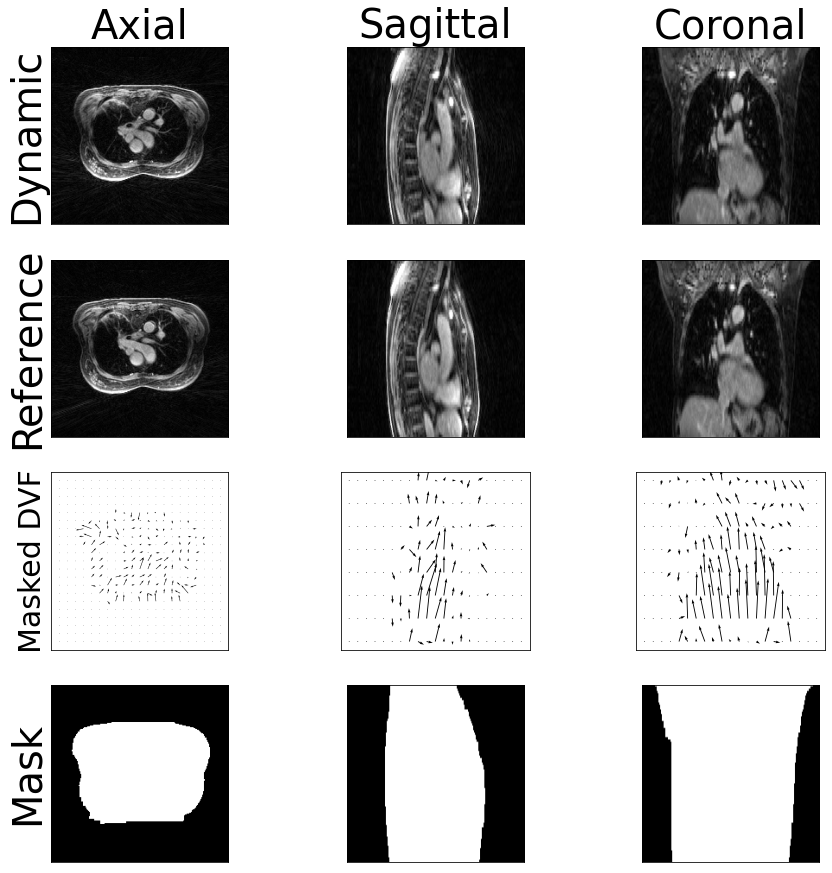

In [48]:
# and show it!
data = train_dataset[int(dataset_idx)]
factor=1

dynamic = data[f'dynamic_{factor}x']['data'].squeeze().numpy()
ref = data[f'reference_{factor}x']['data'].squeeze().numpy()
dvf = data[f'dvf_{factor}x']['data'].squeeze().numpy()
mask = data[f'mask_{factor}x']['data'].squeeze().numpy()

x, y, z, c = dvf.shape
dvf[..., 0] /= (x / 2)
dvf[..., 1] /= (y / 2)
dvf[..., 2] /= (z / 2)

display_training_sample(dynamic, ref, dvf, mask)
plt.show()


In [16]:
# preprocess a HDF5 to extract PyTorch Tensors ready for training
def generate_data(factor, data, slice_width=None, device='cuda'):
    dynamic = data[f'dynamic_{factor}x']['data'].squeeze()
    ref = data[f'reference_{factor}x']['data'].squeeze()
    dvf = data[f'dvf_{factor}x']['data'].squeeze()
    mask = data[f'mask_{factor}x']['data'].squeeze()
    
    # batch size 1 deletes batch dimension, restore
    if len(dynamic.shape) == 3:
        dynamic = dynamic.unsqueeze(0)
        ref = ref.unsqueeze(0)
        dvf = dvf.unsqueeze(0)
        mask = mask.unsqueeze(0)

    b, x, y, z, c = dvf.shape
    dvf[:, ..., 0] /= (x / 2)
    dvf[:, ..., 1] /= (y / 2)
    dvf[:, ..., 2] /= (z / 2)

    if slice_width is not None:
        offset = np.random.randint(low=0, high=z-slice_width-1)
        dynamic = dynamic[:, :, :, offset:offset+slice_width]
        ref = ref[:, :, :, offset:offset+slice_width]
        dvf = dvf[:, :, :, offset:offset+slice_width, :]
        mask = mask[:, :, :, offset:offset+slice_width]


    data_t = torch.cat(
        (dynamic.unsqueeze(1), ref.unsqueeze(1)), 1).permute(0, 1, 4, 3, 2)
    target = dvf.permute(0, 4, 3, 2, 1)

    data_t, target, mask = data_t.to(
        device), target.to(device), mask.permute(0, 3, 2, 1).to(device)

    return data_t, target, mask

In [17]:
# helper function to display some data during training/testing
def display_output(target, output, masks):
    f, ax = plt.subplots(2, 3, figsize=(15, 10))
    b, c, z, y, x = target.shape
    random_batch = np.random.choice(range(b))
    target_dvf = target[random_batch, ...].squeeze().detach().permute(3, 2, 1, 0).cpu().numpy()
    mask = masks[random_batch, ...].squeeze().detach().cpu().numpy()
    output_dvf = output[random_batch, ...].squeeze().detach().permute(3, 2, 1, 0).cpu().numpy()

    display_dvf(target_dvf[..., 0].squeeze(), 
            target_dvf[..., 1].squeeze(), 
            target_dvf[..., 2].squeeze(), 
            z // 2, 
            y // 2, 
            x // 2, 
            x, y, z,
            ax[0, 0], ax[0, 1], ax[0, 2])
    display_dvf(output_dvf[...,0].squeeze(), 
            output_dvf[...,1].squeeze(), 
            output_dvf[...,2].squeeze(), 
            z // 2, 
            y // 2, 
            x // 2, 
            x, y, z,
            ax[1, 0], ax[1, 1], ax[1, 2])
    plt.show()

In [18]:
# Rescale DVF from [-1, 1] to voxels
def to_pixel(field):
    assert(len(field.shape) == 5)
    b, c, z, y, x = field.shape
    assert(c == 3)
    scaled_field = field.clone()
    scaled_field[:, 0, ...] *= (z / 2)
    scaled_field[:, 1, ...] *= (y / 2)
    scaled_field[:, 2, ...] *= (x / 2)
    return scaled_field

# helper function to get DVF magnitude
def magnitude(field):
    assert(len(field.shape) == 5)
    return torch.norm(field, p=2, dim=1)


# Compute the End-point-error between an input and a target DVF within a mask
def EPE(input_flow, target_flow, mask):
    epe = magnitude(target_flow-input_flow)
    return epe[mask==1].mean()


### Metrics

In [19]:
# The absolute error in magnitude between a target DVF and estimated DVF within a mask
def MagnitudeError(input_flow, target_flow, mask):
    target_mag = magnitude(to_pixel(target_flow))[mask==1]
    input_mag = magnitude(to_pixel(input_flow))[mask==1]
    return F.l1_loss(input_mag, target_mag)

# This computes the spatial laplacian of a DVF
# The DVF is convolved with a discrete laplacian kernel in every direction
# This effectively penalizes non-smoothness in the DVF
def laplacian(input_flow):
    laplacian_kernel = torch.tensor([
                                    [[0.,  0., 0.],
                                     [0.,  1., 0.], 
                                     [0.,  0., 0.]],
        
                                    [[0.,  1., 0.],
                                     [1., -6., 1.], 
                                     [0.,  1., 0.]],
        
                                    [[0.,  0., 0.],
                                     [0.,  1., 0.], 
                                     [0.,  0., 0.]]]).view(1, 1, 3, 3, 3).to(device)
    # penalize the laplacian of the dvf
    lap = 0
    flow_ndim = input_flow.shape[1]
    for i in range(flow_ndim):
        lap += torch.norm(F.conv3d(input_flow[:, i, ...].unsqueeze(1), laplacian_kernel, padding=1), p=2, dim=1).mean()
        
    return lap / flow_ndim
    
    
# Computes the angle error between a target DVF and an estimated DVF for every voxel
# Caution is needed to prevent NaNs
def AngleError(input_flow, target_flow, mask):
    uDotv = torch.sum(input_flow * target_flow, dim=1)

    target_mag = magnitude(target_flow)
    input_mag = magnitude(input_flow)

    asdf = (input_mag * target_mag).squeeze()
    angle = uDotv / (asdf + 1e-8)
    
    angle_acos = torch.acos(torch.clamp(angle[(mask == 1) & (target_mag > 0.005)], -1, 1))
    angle_acos[angle_acos != angle_acos] = 0 # filter NaNs
    return F.mse_loss(angle_acos, torch.zeros_like(angle_acos))

In [20]:
# Helper functions: Warp a batch of images using a batch of DVFs
def warp_volume(imgs, dvfs):
    # format: 
    # img: shape b, 1, x, y, z
    # dvf: shape b, 3, x, y, z
    
    # get NumPy arrays on the CPU instead of pytorch tensors
    if not isinstance(imgs, np.ndarray):
        imgs_numpy = imgs.detach().cpu().numpy()
    else:
        imgs_numpy = imgs
        
    if not isinstance(imgs, np.ndarray):
        dvfs_numpy = dvfs.detach().cpu().numpy()
    else:
        dvfs_numpy = dvfs
        
    # sanity checks and check assumptions about the shape
    assert(len(imgs_numpy.shape) == 5)
    assert(len(dvfs_numpy.shape) == 5)
    assert(dvfs_numpy.shape[1] == 3)
    assert(imgs_numpy.shape[1] == 1)
    assert(imgs_numpy.shape[0] == dvfs_numpy.shape[0])
    assert(imgs_numpy.shape[2:] == dvfs_numpy.shape[2:])

    b, c, x, y, z = dvfs_numpy.shape
    xz, yz, dz = (np.meshgrid(range(x), range(y), range(z)))
    indices = [yz, xz, dz]
    
    warped_images = np.zeros_like(imgs_numpy)
    for batch in range(b):
        warped_images[batch, ...] = _warp_volume(imgs_numpy[batch, ...].squeeze(), dvfs_numpy[batch, ...].squeeze(), indices)
        
    return warped_images

def _warp_volume(img, dvf, indices):
    # format: 
    # img: shape    x, y, z
    # dvf: shape 3, x, y, z
    
    
    c, x, y, z = dvf.shape
    newpos = np.zeros((3, x, y, z))
    for i in range(3):
        newpos[i, ...] = indices[i] + dvf[i, ...]

    warped = scipy.ndimage.map_coordinates(img, newpos)
    return warped

## Model training and validation
Now it is finally time to define our train and validation loops

In [21]:
def train_model(model, device, train_loader, optimizer, epoch, pyramid_levels, loss_history, alpha, l):
    model.train()
    epes = []
    smoothnesses = []
    for batch_idx, data in enumerate(tqdm(train_loader)):
        # generate multi-resolution data
        data_4, target_4, mask_4 = generate_data(4, data, None)
        data_2, target_2, mask_2 = generate_data(2, data, None)
        data_1, target_1, mask_1 = generate_data(1, data, None)
        optimizer.zero_grad()
        
        # obtain and mask output
        output_1 = model(data_4, data_2, data_1)
        output_1[:, 0, ...] = output_1[:, 0, ...] * mask_1
        output_1[:, 1, ...] = output_1[:, 1, ...] * mask_1
        output_1[:, 2, ...] = output_1[:, 2, ...] * mask_1
        target_1[:, 0, ...] = target_1[:, 0, ...] * mask_1
        target_1[:, 1, ...] = target_1[:, 1, ...] * mask_1
        target_1[:, 2, ...] = target_1[:, 2, ...] * mask_1
        
        # compute and backpropagate the loss
        smoothness = laplacian(output_1)
        vs_loss = AngleError(output_1, target_1, mask_1) + MagnitudeError(output_1, target_1, mask_1) + l * smoothness
        epe_loss = EPE(output_1, target_1, mask_1)
        loss = alpha*vs_loss + (1-alpha)*epe_loss
        loss.backward()
        
        epes.append(epe_loss.item())
        smoothnesses.append(smoothness.item())
        optimizer.step()
        break

    display_output(output_1, target_1, mask_1)

    loss_history.log(epoch, total_epe_train=np.mean(epes), smoothness_train=np.mean(smoothnesses))

In [22]:
def evaluate_model(model, device, eval_loader, epoch, pyramid_levels, loss_history):
    model.eval()
    epes, aees, angle_errs, iqrs, mags, fs, losses = [], [], [], [], [], [], []
    warping_errors = []
    with torch.no_grad():
        for batch_idx, data in enumerate(tqdm(eval_loader)):
            # same as in training... 
            data_4, target_4, mask_4 = generate_data(4, data, None)
            data_2, target_2, mask_2 = generate_data(2, data, None)
            data_1, target_1, mask_1 = generate_data(1, data, None)

            output_1 = model(data_4, data_2, data_1)
            output_1[:, 0, ...] = output_1[:, 0, ...] * mask_1
            output_1[:, 1, ...] = output_1[:, 1, ...] * mask_1
            output_1[:, 2, ...] = output_1[:, 2, ...] * mask_1
            target_1[:, 0, ...] = target_1[:, 0, ...] * mask_1
            target_1[:, 1, ...] = target_1[:, 1, ...] * mask_1
            target_1[:, 2, ...] = target_1[:, 2, ...] * mask_1
            
            # but now metrics are only collected
            smoothness = laplacian(output_1)
            vs_loss = AngleError(output_1, target_1, mask_1) + MagnitudeError(output_1, target_1, mask_1) + l * smoothness
            epe_loss = EPE(output_1, target_1, mask_1)
            loss = alpha*vs_loss + (1-alpha)*epe_loss
            
            losses.append(loss.item())
            epes.append(epe_loss.item())

            # determine registration loss by computing the MSE between warped dynamic and reference
            warped = torch.from_numpy(warp_volume(data_1[:, 0, ...].unsqueeze(1).permute(0, 1, 4, 3, 2), output_1.permute(0, 1, 4, 3, 2)))
            ref = data_1[:, 1, ...].unsqueeze(1).permute(0, 1, 4, 3, 2).cpu()
            permuted_mask = mask_1.permute(0, 3, 2, 1)
            warped = warped.squeeze()
            ref = ref.squeeze()
            if len(warped.shape) == 3:
                warped = warped.unsqueeze(0)
                
            if len(ref.shape) == 3:
                ref = ref.unsqueeze(0)
            warping_error = F.mse_loss(warped[permuted_mask==1], ref[permuted_mask==1])
            warping_errors.append(warping_error.item())
            break
    loss_history.log(epoch, 
                     total_epe_eval=np.mean(epes), 
                     eval_warp = np.mean(warping_errors))
    return np.mean(losses), np.mean(epes), np.mean(warping_errors)


Now, we run these training and validation routines for `n_epochs` epochs.

In [ ]:
%matplotlib inline
# Hyperparameters
alpha = 0.8
l = 1.e-5
batch_size = 4
lr = 1.e-4
weight_decay = 1e-3
n_epochs = 125
optimizer_name = 'Adam'
train_dataset = torchio.ImagesDataset(
        all_train_data_subject, transform=train_transform)
eval_dataset = torchio.ImagesDataset(
        all_eval_data_subject, transform=eval_transform)
device = torch.device('cuda')
pyramid_levels=3
try:
    del optim
except:
    pass
try:
    del train_loader
except:
    pass
try:
    del eval_loader
except:
    pass
try:
    del loss_history
except:
    pass
try:
    del loss_canvas
except:
    pass
model = model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=24, worker_init_fn=seed_worker)
eval_loader = torch.utils.data.DataLoader(
    eval_dataset, batch_size=batch_size, num_workers=24, worker_init_fn=seed_worker)
loss_history = hl.History()
loss_canvas = hl.Canvas()

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', factor=0.5)

# for every epoch...
for epoch in range(n_epochs):
    # train model on training data
    train_model(model, device, train_loader, optim, epoch, pyramid_levels, loss_history, alpha, l)
    # validate model and generate metrics
    loss, epe, warp = eval_model(model, device, eval_loader, epoch, pyramid_levels, loss_history)
    scheduler.step(loss)
    
    # display metrics
    with loss_canvas:
        loss_canvas.draw_plot([loss_history["total_epe_train"], loss_history["total_epe_eval"]], labels=['EPE (train)','EPE (evaluation)'])
        loss_canvas.draw_plot([loss_history["smoothness_train"]], labels=['Smoothness'])
        loss_canvas.draw_plot([loss_history["eval_warp"]], labels=['Registration error'])
    
    # save model!
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'model_1_state_dict': model.model_1.state_dict(),
                'model_2_state_dict': model.model_2.state_dict(),
                'model_3_state_dict': model.model_3.state_dict(),
                'optimizer_state_dict': optim.state_dict(),
                'loss': loss,
                'EPE': epe,
                'warping_error': warp
    }, f'/path/to/model/TEMPEST_L0L1L2_epoch_{epoch}.pth')
